# Введение в методы анализа данных. Язык Python.

## Лекция 10. Обучение без учителя
<br><br><br><br>
__Аксентьев Артем (akseart@ya.ru)__

__Ксемидов Борис (nstalker.anonim@yandex.ru)__
<br>

Входные данные:
- только X (описания множества объектов (обучающей выборки)).

Цель:
- обнаружить внутренние взаимосвязи, зависимости, закономерности, существующие между объектами.

## Обучение с учителем

__Плюсы:__
- хорошо решает чётко определенные задачи с множеством меток;
- есть метки, следовательно, есть возможность измерения ошибки.

__Минусы:__
- не справляется с "размытыми" плохо определенными задачами с отсутствующими метками;
- система ограничивается метками с обучающей выборки из-за чего может не знать о существовании возможных других;
- разметка данных - довольно трудоёмкая задача.

__Примеры:__
- большое множество изображений с метками того, что на них изображено.

## Обучение без учителя

__Плюсы:__
- не нужна разметка данных (очень большой плюс, особенно, когда постоянно появляются какие-то новые группы данных, либо группы вообще неизвестны, либо нет возможности разметить данные);
- хорошо справляется с нечетко определенными задачами (система изучает структуру данных).

__Минусы:__
- полученные группы объектов не имеют "названия" (может быть необходимо вмешательство человека);
- менее пригодно для решения чётко сформулированных задач со строгой формулировкой (в отличие от обучения с учителем).

__Примеры:__
- большое множество изображений без меток (группировка изображений, исходя их схожести изображение между собой, то есть используя только описания изображений - таким образом можно разметить данные гораздо быстрее, то есть присваивать метки именно группам).

## Алгоритмы обучения без учителя
- Понижение размерности:
    - линейная проекция ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), [случайная проекция](https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.GaussianRandomProjection.html));
    - нелинейное снижение размерности ([Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html), [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), [ICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html)).
- Кластеризация:
    - метод k-средних;
    - иерархическая кластеризация;
    - DBSCAN.

## Задачи обучения без учителя
- обнаружение аномалий (при обучении и при прогнозировании);
- сегментирование групп;
- регуляризация.

In [1]:
from matplotlib import pyplot as plt

def set_style():
    COLOR = 'white'
    plt.rcParams['text.color'] = COLOR
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR

set_style()

## PCA

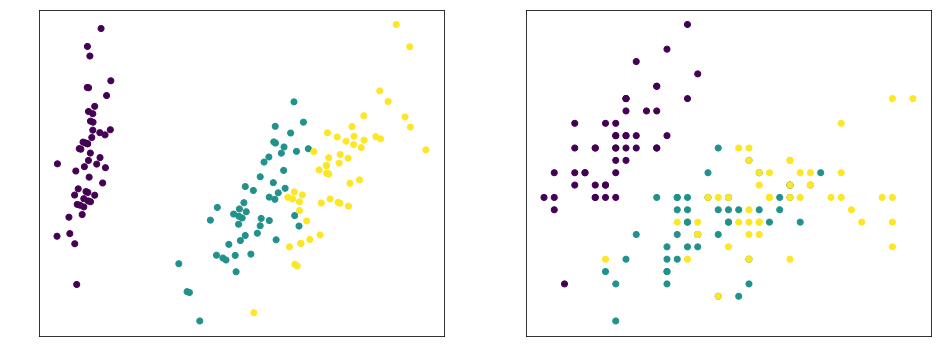

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import datasets

iris = datasets.load_iris()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
X_reduced = PCA(n_components=2).fit_transform(iris.data)
ax[0].scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=iris.target
)

X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

ax[1].scatter(
    X[:, 0],
    X[:, 1],
    c=y
)

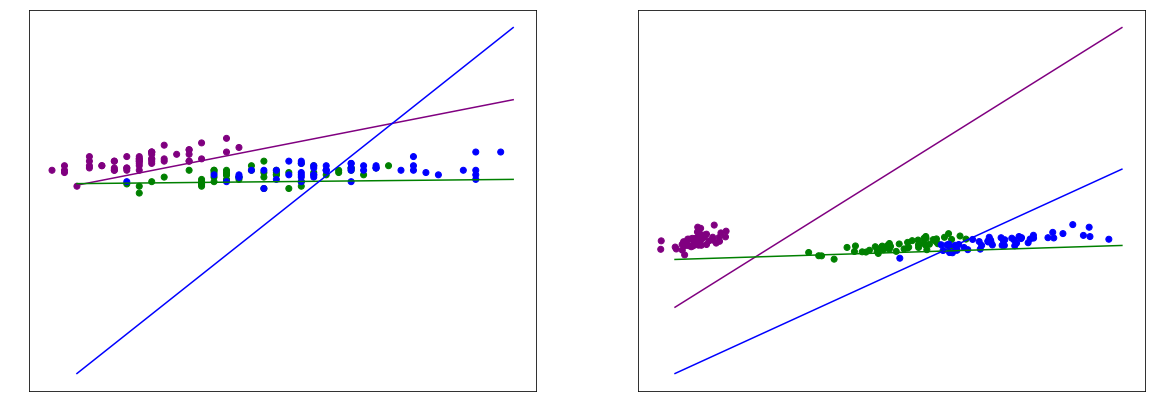

In [4]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import numpy as np
from matplotlib.colors import ListedColormap

def lin_log(w, b):
    def func(x):
        return (0.5 - w[0] * x - b) / w[1]
    return func


def plot_lines(g, model, min_v, max_v, colors):
    for w, b, color in zip(model.coef_, model.intercept_, colors):
        linear = lin_log(w, b)
        grid_x = np.linspace(min_v, max_v, 200)
        grid_y = linear(grid_x)
        g.plot(grid_x, grid_y, color=color)

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
colors = ["purple", "green", "blue"]
multi = "ovr"

# Without PCA
clf = LogisticRegression(
    random_state=42, multi_class=multi).fit(X, y)

ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(colors))
plot_lines(ax[0], clf, 4.5, 8, colors)

# With PCA
clf_pca = LogisticRegression(
    random_state=42, multi_class=multi).fit(X_reduced, y)

plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=y, cmap=ListedColormap(colors))
plot_lines(ax[1], clf_pca, -3, 4, colors)

In [9]:
from sklearn.metrics import accuracy_score

accuracy_score(clf_pca.predict(X_reduced[:50]), y[:50])

1.0

In [26]:
from sklearn.metrics import accuracy_score

accuracy_score(y, clf_pca.predict(X_reduced)), accuracy_score(y, clf.predict(X))

(0.9666666666666667, 0.9)

## Кластеризация

### K-means

Алгоритм ([источник](https://wiki.loginom.ru/articles/k-means.html)):
1. Выбирается число кластеров k.
2. Из исходного множества данных случайным образом выбираются k наблюдений, которые будут служить начальными центрами кластеров.
3. Для каждого наблюдения исходного множества определяется ближайший к нему центр кластера (расстояния измеряются в метрике Евклида). При этом записи, «притянутые» определенным центром, образуют начальные кластеры.
4. Вычисляются центроиды — центры тяжести кластеров. Каждый центроид — это вектор, элементы которого представляют собой средние значения соответствующих признаков, вычисленные по всем записям кластера.
5. Центр кластера смещается в его центроид, после чего центроид становится центром нового кластера.
6. 3-й и 4-й шаги итеративно повторяются. Очевидно, что на каждой итерации происходит изменение границ кластеров и смещение их центров. В результате минимизируется расстояние между элементами внутри кластеров и увеличиваются междукластерные расстояния.

Остановка алгоритма производится тогда, когда границы кластеров и расположения центроидов не перестанут изменяться от итерации к итерации, т.е. на каждой итерации в каждом кластере будет оставаться один и тот же набор наблюдений. На практике алгоритм обычно находит набор стабильных кластеров за несколько десятков итераций.

-63.8199420220013


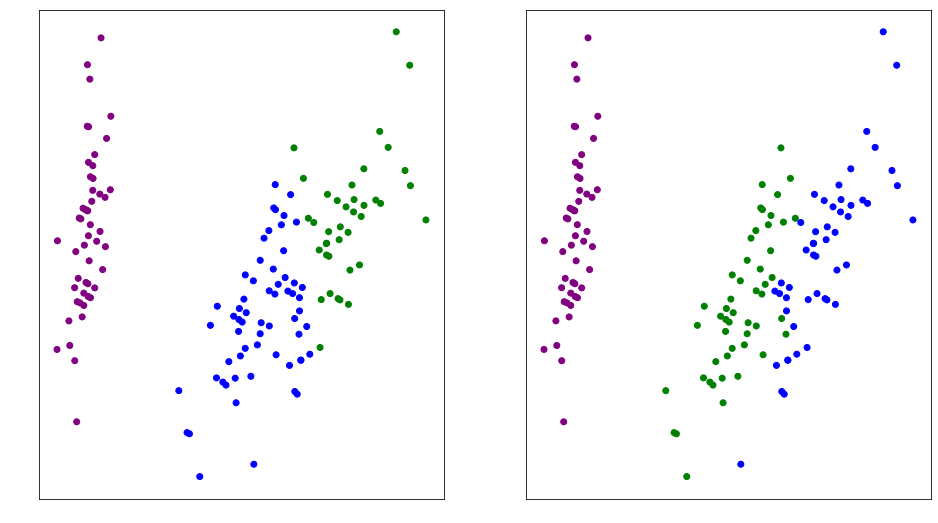

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_reduced)
y = kmeans.predict(X_reduced)


fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=y,
    cmap=ListedColormap(colors))
ax[1].scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=iris.target,
    cmap=ListedColormap(colors))

print(kmeans.score(X_reduced))

### Иерархическая кластеризация

Алгоритмы иерархической кластеризации бывают двух типов:
- разделяющий (это нисходящий подход, при котором изначально все данные рассматриваются как одна группа, а затем итеративно разбиваются данные на подгруппы);
- агломерационный (Это восходящий подход, основанный на объединении кластеров).

Метрики для объединения:
- min;
- max;
- среднее.

Первоначально данные разбиваются на m одноэлементных кластеров (где значение m - это количество выборок / точек данных). Два кластера объединяются в один итеративно, что сокращает количество кластеров в каждой итерации. Этот процесс объединения кластеров останавливается, когда все кластеры объединяются в одно или достигается желаемое количество кластеров.

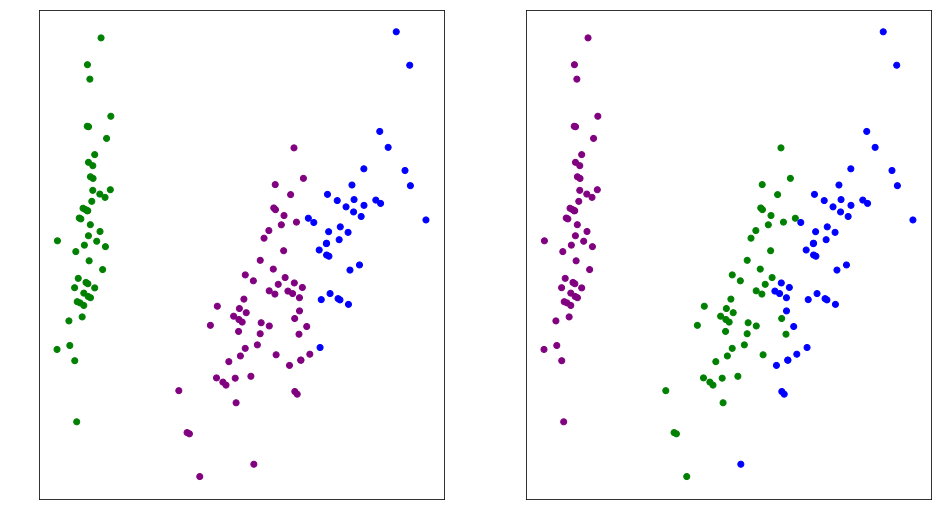

In [57]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3).fit(X_reduced)
colors_dbscan = {-1:'red', 0:'purple', 1:'green', 2:'blue'}


fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=pd.Series(clustering.labels_).map(colors_dbscan))
ax[1].scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=iris.target,
    cmap=ListedColormap(colors)
)

### DBSCAN

[-1  0  1  2]


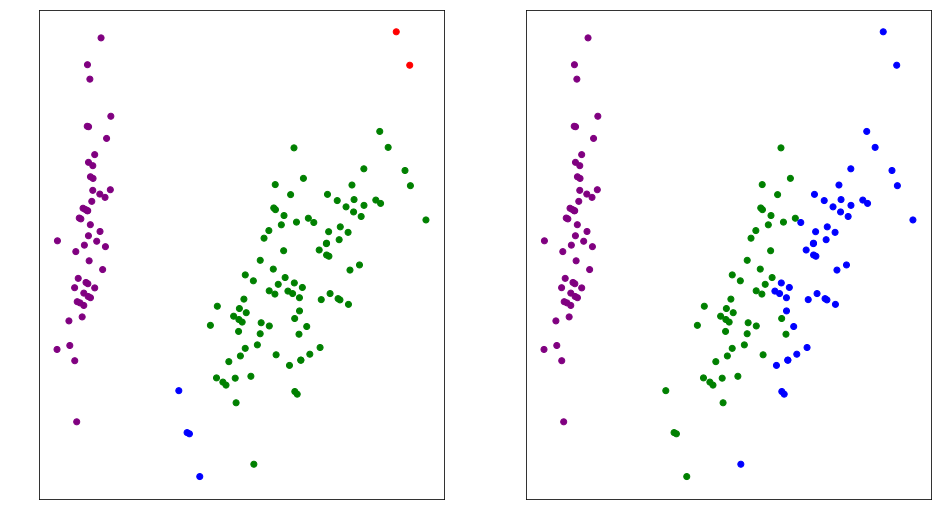

In [38]:
import seaborn as sns
from sklearn.cluster import DBSCAN
import pandas as pd

# eps - максимальное расстояние между двумя точками, при котором они еще могут считаться соседними
# min_samples - ми­ нимальное количество образцов, позволяющее назвать группу кластером
clustering = DBSCAN(eps=0.5, min_samples=3).fit(X_reduced)
print(np.unique(clustering.labels_))
colors_dbscan = {-1:'red', 0:'purple', 1:'green', 2:'blue'}


fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=pd.Series(clustering.labels_).map(colors_dbscan))
ax[1].scatter(
    X_reduced[:, 0], X_reduced[:, 1],
    c=iris.target,
    cmap=ListedColormap(colors)
)

## Обнаружение аномалий

[-1  0  1  2]


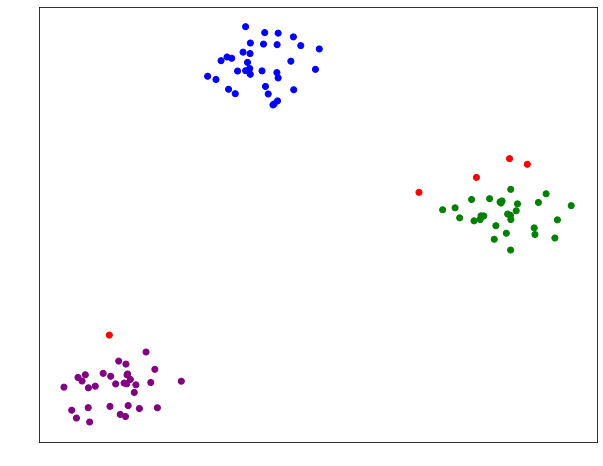

In [54]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=3, n_features=2,
                  random_state=42)


clustering = DBSCAN(eps=1, min_samples=3).fit(X)
print(np.unique(clustering.labels_))
colors_dbscan = {-1:'red', 0:'purple', 1:'green', 2:'blue'}

plt.figure(figsize=(10, 8))
plt.scatter(
    X[:, 0], X[:, 1],
    c=pd.Series(clustering.labels_).map(colors_dbscan))

Дополнительный материал:
- [Сравнение алгоритмов кластеризации](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)
- Прикладное машинное обучение без учителя с использованием Python | Анкур Пател